## Setup

Requirements:


In [526]:
#Load Packages
import pandas as pd
import numpy as np
import patsy as pt
import plotly.express as px
import nbformat
import plotly as py
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from pygam import LinearGAM, s, f
import statsmodels.api as sm
import statsmodels.tsa.stattools as st


In [527]:
#Load Data
data = pd.read_csv("data/amazon-purchases.csv")
survey_data = pd.read_csv("data/survey.csv")

# Data Pre-Processing

In [528]:
#Add a prime purchase column to the data

#Create a list with prime days inside it
prime_days = ["2022-07-12", "2022-07-13", "2021-06-21", "2021-06-22", "2020-10-13", "2020-10-14", "2019-07-15", "2019-07-16", "2018-07-17", "2018-07-18",]

prime_purchase = []
for i in data["Order Date"]:
    if i in prime_days:
        prime_purchase.append(1)
    else:
        prime_purchase.append(0)
data["Prime Purchase"] = prime_purchase

In [529]:
#Use prime purchase data to create a prime day customer list
prime_day_customer = []
for i in range(len(data)):
    if data["Prime Purchase"][i] == 1:
        prime_day_customer.append(data["Survey ResponseID"][i])
prime_day_customer = set(prime_day_customer)

prime_customer = []
for i in data["Survey ResponseID"]:
    if i in prime_day_customer:
        prime_customer.append(1)
    else:
        prime_customer.append(0)

data["Prime Customer"] = prime_customer

In [530]:
# Merge the purchase data with customer surveys on 'Survey ResponseID'
merged_data = pd.merge(data, survey_data, on='Survey ResponseID', how='inner')

In [531]:
subset_data = merged_data[(merged_data['Q-demos-gender'] == 'Female') & (merged_data['Q-demos-age'] != '65 and older') & (merged_data['Prime Customer'] == 1) & (merged_data['Q-amazon-use-howmany']=='1 (just me!)') & (merged_data['Order Date']<'2022-12-21')]

In [532]:
#Calculate Revenue to use in forecast
subset_data['Revenue'] = subset_data['Quantity'] * subset_data['Purchase Price Per Unit']

C:\Users\nicko\AppData\Local\Temp\ipykernel_16364\2637245334.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [533]:
subset_data['Order Date'].max()

'2022-12-20'

Data exploration

In [534]:
unique_responses_by_gender = merged_data.groupby('Q-demos-gender')['Survey ResponseID'].nunique()
print(unique_responses_by_gender)

Q-demos-gender
Female               2589
Male                 2311
Other                 116
Prefer not to say      11
Name: Survey ResponseID, dtype: int64


In [535]:
subset_data['Order Date'].max()
record = subset_data[merged_data['Order Date'] == subset_data['Order Date'].max()]
record

C:\Users\nicko\AppData\Local\Temp\ipykernel_16364\4112819008.py:2: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



,Order Date,Purchase Price Per Unit,Quantity,Shipping Address State,Title,ASIN/ISBN (Product Code),Category,Survey ResponseID,Prime Purchase,Prime Customer,...,Q-substance-use-alcohol,Q-personal-diabetes,Q-personal-wheelchair,Q-life-changes,Q-sell-YOUR-data,Q-sell-consumer-data,Q-small-biz-use,Q-census-use,Q-research-society,Revenue
28055,2022-12-20,12.79,1.0,MI,LEADO 32oz 1Liter Motivational Water Bottle w/...,B07VKM99K4,BOTTLE,R_10YnFpDzlwQlmrX,0,1,...,Yes,No,No,NaN,No,No,No,No,Yes,12.79
28056,2022-12-20,27.99,1.0,MI,Harry Potter Trinket Dish Set - Ring Jewelry T...,B0916DJ7HF,JEWELRY_STORAGE,R_10YnFpDzlwQlmrX,0,1,...,Yes,No,No,NaN,No,No,No,No,Yes,27.99
28057,2022-12-20,20.99,1.0,MI,"LED Beanie with Light,Unisex USB Rechargeable ...",B08L359TZ4,HAT,R_10YnFpDzlwQlmrX,0,1,...,Yes,No,No,NaN,No,No,No,No,Yes,20.99
31868,2022-12-20,12.16,1.0,NC,7.9% Bifenthrin Concentrate for Insect Control...,B00ARKSC4E,PESTICIDE,R_111Pbqb8YG1rP4o,0,1,...,Yes,No,No,Had a child,No,No,Yes,Yes,Yes,12.16
32365,2022-12-20,10.99,3.0,AR,Paper Ice Cream Cups - 50-Count 5.5-Oz Disposa...,B07Z69F36R,DISHWARE_BOWL,R_117LDoOnJxdPvkb,0,1,...,Yes,No,No,NaN,Yes if I get part of the profit,Yes if consumers get part of the profit,Yes,Yes,Yes,32.97
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1841348,2022-12-20,11.89,1.0,PA,"OLLY Kids Immunity Gummy, Immune Support, Well...",B01F7VS6T8,VITAMIN,R_yxxiDkqLBNLD3S9,0,1,...,Yes,No,No,NaN,Yes,Yes,Yes,Yes,Yes,11.89
1846149,2022-12-20,15.26,1.0,CA,Nizoral Anti-Dandruff Shampoo with 1% Ketocona...,B00AINMFAC,SHAMPOO,R_z89cVoCKmGUboYN,0,1,...,No,No,No,NaN,No,No,No,No,No,15.26
1850621,2022-12-20,16.99,1.0,OH,2022 Score Football Trading Cards Cello Value ...,B0BLG9B9CZ,TRADING_CARDS_FACTORY_SEALED,R_zfnsck2ZatnGtY5,0,1,...,Yes,No,No,NaN,No,No,Yes,I don't know,Yes,16.99
1850622,2022-12-20,15.66,1.0,OH,2021 Panini Donruss NFL Football 30 Card Value...,B09HPC41XL,TRADING_CARDS_FACTORY_SEALED,R_zfnsck2ZatnGtY5,0,1,...,Yes,No,No,NaN,No,No,Yes,I don't know,Yes,15.66


In [537]:
# Convert 'Order Date' to datetime
subset_data['Order Date'] = pd.to_datetime(subset_data['Order Date'])

# Group by 'Order Date' and sum the 'Purchase Price Per Unit'
transaction_totals = subset_data.groupby(['Order Date', 'Q-demos-gender'])['Purchase Price Per Unit'].sum().reset_index()

# Plot the time series
px.line(transaction_totals, x='Order Date', y='Purchase Price Per Unit', title='Transaction Totals Over Time')

C:\Users\nicko\AppData\Local\Temp\ipykernel_16364\758613859.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [538]:
subset_data['Year'] = subset_data['Order Date'].dt.year
subset_data['Month'] = subset_data['Order Date'].dt.month
subset_data['Day'] = subset_data['Order Date'].dt.day
subset_data['Day of Week'] = subset_data['Order Date'].dt.dayofweek

C:\Users\nicko\AppData\Local\Temp\ipykernel_16364\1763971896.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\nicko\AppData\Local\Temp\ipykernel_16364\1763971896.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\nicko\AppData\Local\Temp\ipykernel_16364\1763971896.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/panda

In [539]:
subset_data.head()

,Order Date,Purchase Price Per Unit,Quantity,Shipping Address State,Title,ASIN/ISBN (Product Code),Category,Survey ResponseID,Prime Purchase,Prime Customer,...,Q-sell-YOUR-data,Q-sell-consumer-data,Q-small-biz-use,Q-census-use,Q-research-society,Revenue,Year,Month,Day,Day of Week
140,2018-01-18,17.16,1.0,PA,"NOW Foods, Certified Organic Better Stevia, Ex...",B005F9XFN0,SUGAR_SUBSTITUTE,R_037XK72IZBJyF69,0,1,...,Yes if I get part of the profit,Yes if consumers get part of the profit,I don't know,No,Yes,17.16,2018,1,18,3
141,2018-01-18,6.49,1.0,PA,"F.M. Brown'S Encore Parakeet Food, 5-Pound",B000HHSHZG,PET_FOOD,R_037XK72IZBJyF69,0,1,...,Yes if I get part of the profit,Yes if consumers get part of the profit,I don't know,No,Yes,6.49,2018,1,18,3
142,2018-01-18,14.99,1.0,PA,COTTON CRAFT - Scandia Stripe 12 Pack - Pure C...,B014V1IYEM,TOWEL,R_037XK72IZBJyF69,0,1,...,Yes if I get part of the profit,Yes if consumers get part of the profit,I don't know,No,Yes,14.99,2018,1,18,3
143,2018-01-18,12.99,1.0,PA,"XREXS 4 Channels Digital Kitchen Timer Clock, ...",B01K4JKFK6,TIMER,R_037XK72IZBJyF69,0,1,...,Yes if I get part of the profit,Yes if consumers get part of the profit,I don't know,No,Yes,12.99,2018,1,18,3
144,2018-01-18,12.87,1.0,PA,Premium Wrist Rests for Keyboard and Mouse Pad...,B01A92ETXM,WRIST_REST,R_037XK72IZBJyF69,0,1,...,Yes if I get part of the profit,Yes if consumers get part of the profit,I don't know,No,Yes,12.87,2018,1,18,3


In [547]:
# Group by cluster and Date and aggregate the quantity and purchase prices
aggregated_data = subset_data.groupby(['Order Date']).agg({
    'Quantity': 'sum',
    'Revenue': 'sum',
    'Prime Purchase': lambda x: 1 if x.sum() > 0 else 0,
    'Prime Customer': 'sum'
}).reset_index()

#Add a column for the year, month, day, and day of the week
aggregated_data['Year'] = aggregated_data['Order Date'].dt.year
aggregated_data['Month'] = aggregated_data['Order Date'].dt.month
aggregated_data['Day'] = aggregated_data['Order Date'].dt.day
aggregated_data['Day of Week'] = aggregated_data['Order Date'].dt.dayofweek

# Display the first few rows of the aggregated data
aggregated_data['prime_proportion'] = aggregated_data['Prime Customer'] / aggregated_data['Quantity']
aggregated_data.head()

,Order Date,Quantity,Revenue,Prime Purchase,Prime Customer,Year,Month,Day,Day of Week,prime_proportion
0,2018-01-01,201.0,3091.23,0,189,2018,1,1,0,0.940299
1,2018-01-02,173.0,2986.71,0,159,2018,1,2,1,0.919075
2,2018-01-03,184.0,3325.05,0,163,2018,1,3,2,0.885870
3,2018-01-04,181.0,3286.29,0,167,2018,1,4,3,0.922652
4,2018-01-05,142.0,3786.45,0,126,2018,1,5,4,0.887324


# Specify and Prepare the Model Type

In [549]:
#Exponential Smoothing
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.api import SimpleExpSmoothing
import plotly_express as px

px.line(aggregated_data, x='Order Date', y='Revenue')

In [550]:
aggregated_data

,Order Date,Quantity,Revenue,Prime Purchase,Prime Customer,Year,Month,Day,Day of Week,prime_proportion
0,2018-01-01,201.0,3091.23,0,189,2018,1,1,0,0.940299
1,2018-01-02,173.0,2986.71,0,159,2018,1,2,1,0.919075
2,2018-01-03,184.0,3325.05,0,163,2018,1,3,2,0.885870
3,2018-01-04,181.0,3286.29,0,167,2018,1,4,3,0.922652
4,2018-01-05,142.0,3786.45,0,126,2018,1,5,4,0.887324
...,...,...,...,...,...,...,...,...,...,...
1810,2022-12-16,316.0,7339.47,0,304,2022,12,16,4,0.962025
1811,2022-12-17,361.0,8042.63,0,355,2022,12,17,5,0.983380
1812,2022-12-18,356.0,8120.65,0,328,2022,12,18,6,0.921348
1813,2022-12-19,314.0,6557.15,0,305,2022,12,19,0,0.971338


In [551]:
revenue = aggregated_data['Revenue']
revenue.index = aggregated_data['Order Date']

expModel = ExponentialSmoothing(revenue, trend='add', seasonal='add', seasonal_periods=30).fit()

expForecast = expModel.forecast(90)

C:\Users\nicko\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\nicko\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



In [552]:
import plotly.graph_objects as go

# Create a DataFrame with the actual revenue and the forecasts
smoothData = pd.DataFrame({
        'Truth': revenue.values,
        'Model': expModel.fittedvalues
}, index=revenue.index)

# Add the forecasts to the DataFrame
forecast_dates = pd.date_range(start=revenue.index[-1], periods=90, freq='D')
forecast_df = pd.DataFrame({
        'Forecast': expForecast
}, index=forecast_dates)

# Combine the actual and forecast data
combined_data = pd.concat([smoothData, forecast_df])

# Plot the data
fig = px.line(combined_data, y=['Truth', 'Model', 'Forecast'], 
              title='Exponential Smoothing Forecast', 
              labels={'value': 'Revenue', 'variable': 'Type'},
                          x=combined_data.index,
                          color_discrete_map={
                                  "Truth": 'blue',
                                  'Moedl': 'red',
                                  'Forecast': 'red'
                          })

fig.show()

GAMs

In [553]:
#Abhi's GAM
#!pip install pygam

In [554]:
aggregated_data.head()

,Order Date,Quantity,Revenue,Prime Purchase,Prime Customer,Year,Month,Day,Day of Week,prime_proportion
0,2018-01-01,201.0,3091.23,0,189,2018,1,1,0,0.940299
1,2018-01-02,173.0,2986.71,0,159,2018,1,2,1,0.919075
2,2018-01-03,184.0,3325.05,0,163,2018,1,3,2,0.885870
3,2018-01-04,181.0,3286.29,0,167,2018,1,4,3,0.922652
4,2018-01-05,142.0,3786.45,0,126,2018,1,5,4,0.887324


In [555]:
from sklearn.model_selection import train_test_split

x = aggregated_data[["Year", "Month", "Day", "Weekday", "prime_proportion"]]
y = aggregated_data["Revenue"]

# Split into training and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

KeyError: "['Weekday'] not in index"

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     45.5985
Link Function:                     IdentityLink Log Likelihood:                                 -29444.844
Number of Samples:                         1815 AIC:                                            58982.8851
                                                AICc:                                            58985.395
                                                GCV:                                          4640271.8069
                                                Scale:                                        4430911.6793
                                                Pseudo R-Squared:                                   0.3961
Feature Function                  Lam

C:\Users\nicko\AppData\Local\Temp\ipykernel_16364\1876165514.py:7: UserWarning:

KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 




<Figure size 640x480 with 0 Axes>

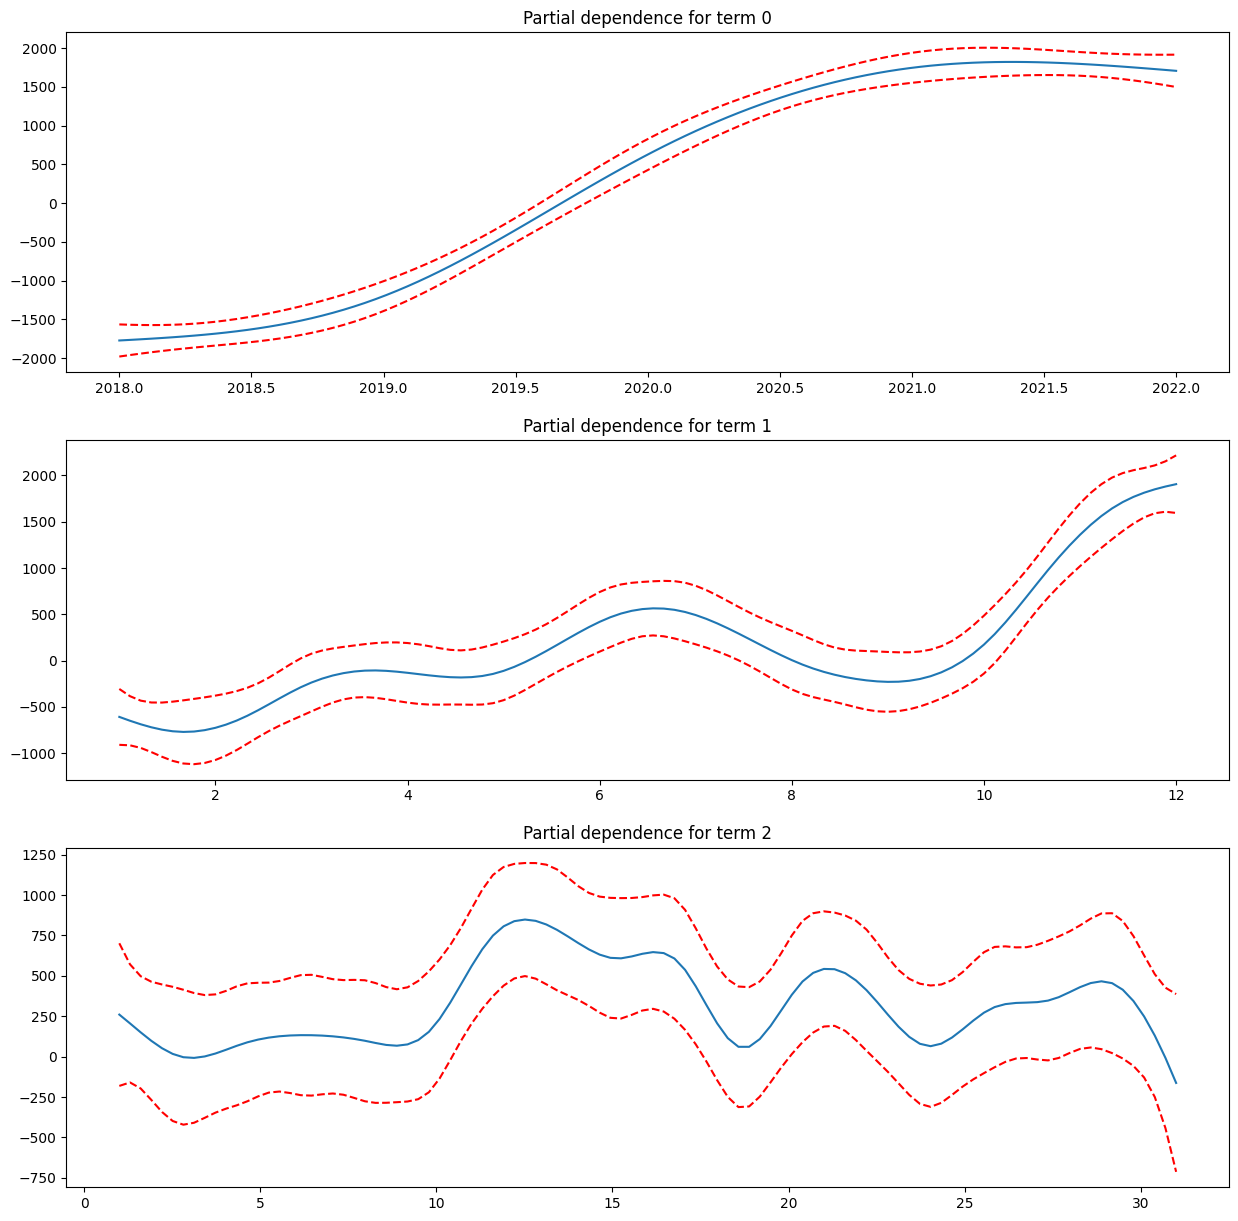

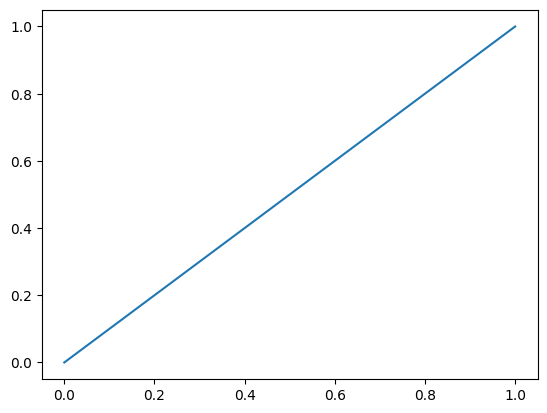

[[2018.            0.            0.            0.            0.        ]
 [2018.04040404    0.            0.            0.            0.        ]
 [2018.08080808    0.            0.            0.            0.        ]
 [2018.12121212    0.            0.            0.            0.        ]
 [2018.16161616    0.            0.            0.            0.        ]
 [2018.2020202     0.            0.            0.            0.        ]
 [2018.24242424    0.            0.            0.            0.        ]
 [2018.28282828    0.            0.            0.            0.        ]
 [2018.32323232    0.            0.            0.            0.        ]
 [2018.36363636    0.            0.            0.            0.        ]
 [2018.4040404     0.            0.            0.            0.        ]
 [2018.44444444    0.            0.            0.            0.        ]
 [2018.48484848    0.            0.            0.            0.        ]
 [2018.52525253    0.            0.            0.  

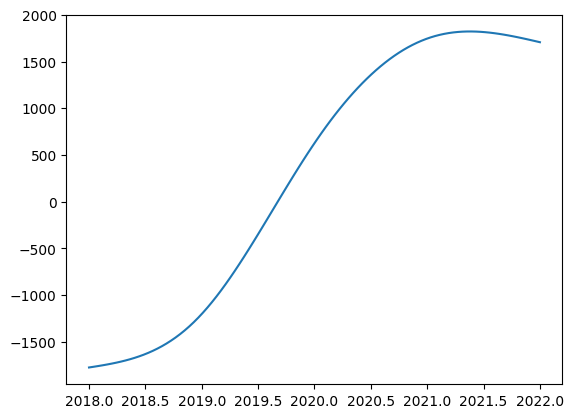

In [ ]:
from pygam import LinearGAM

# Assuming gam is your trained LinearGAM model
gam = LinearGAM().fit(x, y)

# Plot partial dependence
gam.summary()  # Summary should list all feature splines

# Plot each term (feature)
import matplotlib.pyplot as plt
plt.figure()
fig, axs = plt.subplots(nrows=3, figsize=(15, 15))  # Adjust nrows to the number of features

for i, ax in enumerate(axs):
    XX = gam.generate_X_grid(term=i)
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX))
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX, width=.95)[1], c='r', ls='--')
    ax.set_title(f"Partial dependence for term {i}")
plt.show()

import matplotlib.pyplot as plt

plt.plot([0, 1], [0, 1])
plt.show()

XX = gam.generate_X_grid(term=0)
print(XX)
pd = gam.partial_dependence(term=0, X=XX)
plt.plot(XX[:, 0], pd)
plt.show()

In [ ]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Select only the first two columns of x_test
x_test_selected = x_test.iloc[:, :5]

y_pred = gam.predict(x_test_selected)
print("R^2:", r2_score(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", mean_squared_error(y_test, y_pred) ** 0.5)

R^2: 0.4783714613307575
MAE: 1018.6441713948336
RMSE: 1793.360742933473


In [ ]:
x_test_selected

,Year,Month,Day,Day of Week,prime_proportion
567,2019,7,22,0,0.934783
432,2019,3,9,5,0.942308
1750,2022,10,17,0,0.914956
674,2019,11,6,2,0.911111
111,2018,4,22,6,0.973404
...,...,...,...,...,...
1125,2021,1,30,5,0.914894
1142,2021,2,16,1,0.928977
1512,2022,2,21,0,0.921466
170,2018,6,20,2,0.951351


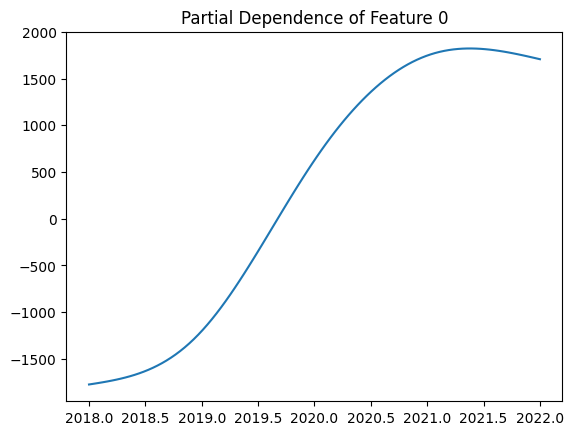

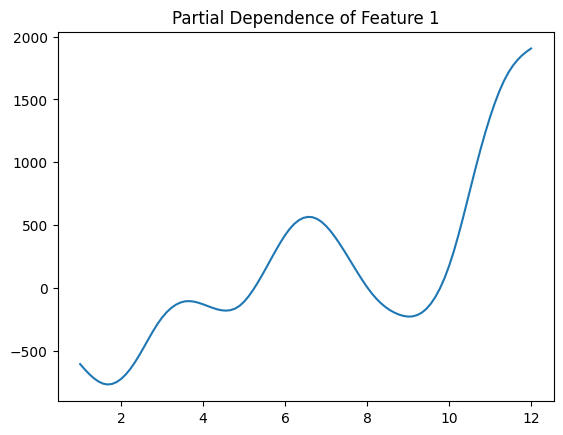

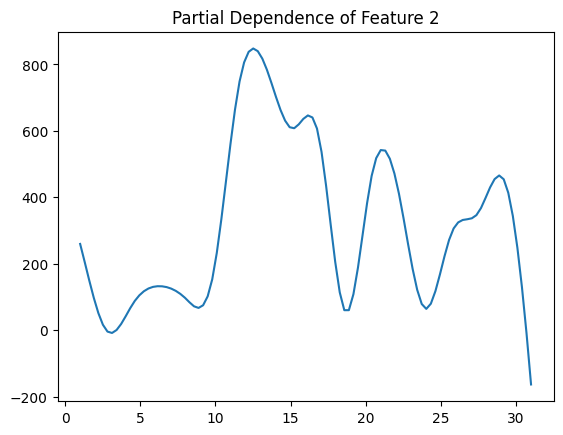

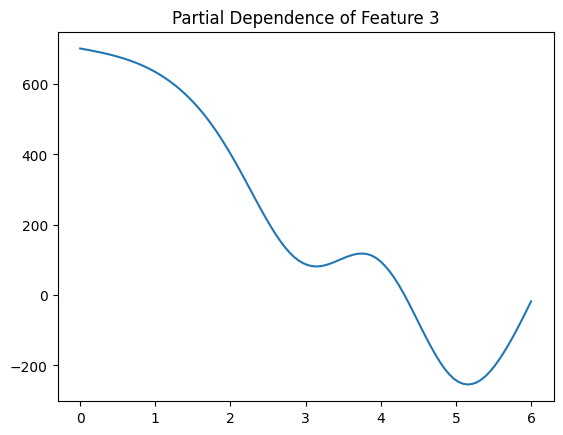

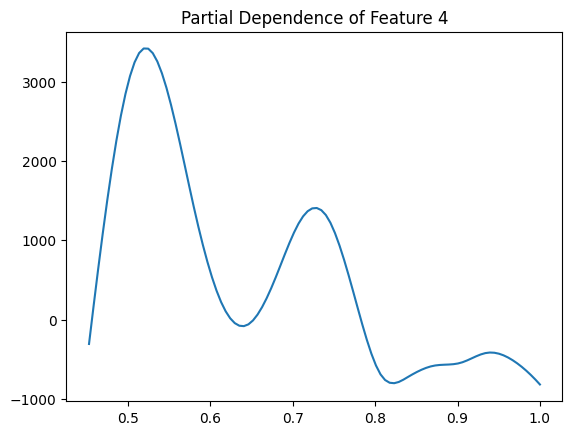

In [ ]:
import matplotlib.pyplot as plt
for i, term in enumerate(gam.terms):
    if term.isintercept:
        continue
    XX = gam.generate_X_grid(term=i)
    plt.plot(XX[:, i], gam.partial_dependence(term=i, X=XX))
    plt.title(f"Partial Dependence of Feature {i}")
    plt.show()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

endDate = pd.to_datetime("2022-12-21")
# Generate dates for the next 3 months
future_dates = pd.date_range(start=endDate, periods=90, freq="D")

# Generate the same features as used in the training data
future_features = pd.DataFrame({
    "Year": future_dates.year,
    "Month": future_dates.month,
    "Day": future_dates.day,
    "Weekday": future_dates.weekday,
    "prime_proportion": 0.5  # Assume 50% prime customers
})

# Assume `gam` is your trained LinearGAM model
future_predictions = gam.predict(future_features)

# Get confidence intervals
intervals = gam.prediction_intervals(future_features, width=0.95)
lower = intervals[:, 0]  # Lower bounds
upper = intervals[:, 1]  # Upper bounds

# Plot the results
import plotly.express as px

fig = px.line(x=future_dates, y=future_predictions, labels={'x': 'Date', 'y': 'Revenue'}, title='Predicted Daily Revenue for the Next 3 Months')
fig.add_scatter(x=future_dates, y=lower, mode='lines', line=dict(color='gray'), name='Lower Bound')
fig.add_scatter(x=future_dates, y=upper, mode='lines', line=dict(color='gray'), name='Upper Bound', fill='tonexty')
fig.show()

# Save predictions to a CSV
# predictions_df = pd.DataFrame({
#     "date": future_dates,
#     "predicted_revenue": future_predictions,
#     "lower_bound": lower,
#     "upper_bound": upper
# })
# predictions_df.to_csv("revenue_predictions.csv", index=False)

In [ ]:
aggregated_data.head()

In [ ]:
x = aggregated_data[["Year", "Month", "Day"]]
y = aggregated_data["Revenue"]

In [ ]:
x.values

In [ ]:
# Initialize and fit the model
gam = LinearGAM(s(0) + s(1) + s(2))
gamFit = gam.gridsearch(x.values, y)

In [557]:
aggregated_data.set_index('Order Date', inplace=True)

In [558]:
aggregated_data['prime_proportion'] = aggregated_data['Prime Customer'] / aggregated_data['Quantity']

In [559]:
aggregated_data

,Quantity,Revenue,Prime Purchase,Prime Customer,Year,Month,Day,Day of Week,prime_proportion
Order Date,,,,,,,,,
2018-01-01,201.0,3091.23,0,189,2018,1,1,0,0.940299
2018-01-02,173.0,2986.71,0,159,2018,1,2,1,0.919075
2018-01-03,184.0,3325.05,0,163,2018,1,3,2,0.885870
2018-01-04,181.0,3286.29,0,167,2018,1,4,3,0.922652
2018-01-05,142.0,3786.45,0,126,2018,1,5,4,0.887324
...,...,...,...,...,...,...,...,...,...
2022-12-16,316.0,7339.47,0,304,2022,12,16,4,0.962025
2022-12-17,361.0,8042.63,0,355,2022,12,17,5,0.983380
2022-12-18,356.0,8120.65,0,328,2022,12,18,6,0.921348


C:\Users\nicko\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\nicko\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



                                     SARIMAX Results                                     
Dep. Variable:                           Revenue   No. Observations:                 1815
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood              -14848.212
Date:                           Mon, 16 Dec 2024   AIC                          29712.425
Time:                                   20:47:23   BIC                          29756.420
Sample:                               01-01-2018   HQIC                         29728.662
                                    - 12-20-2022                                         
Covariance Type:                             opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
prime_proportion -2280.4710    508.630     -4.484      0.000   -3277.368   -1283.574
Prime Purchase    5571.55

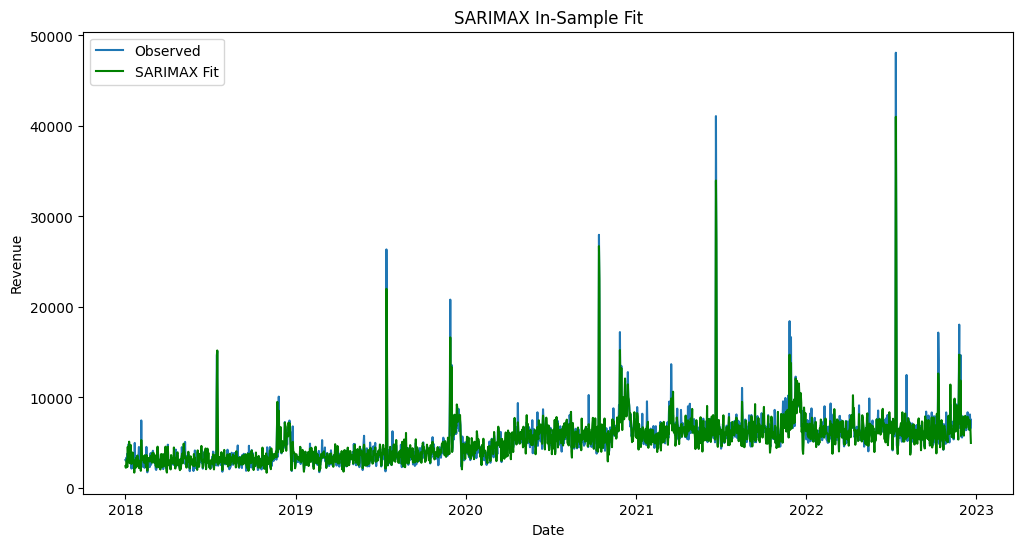

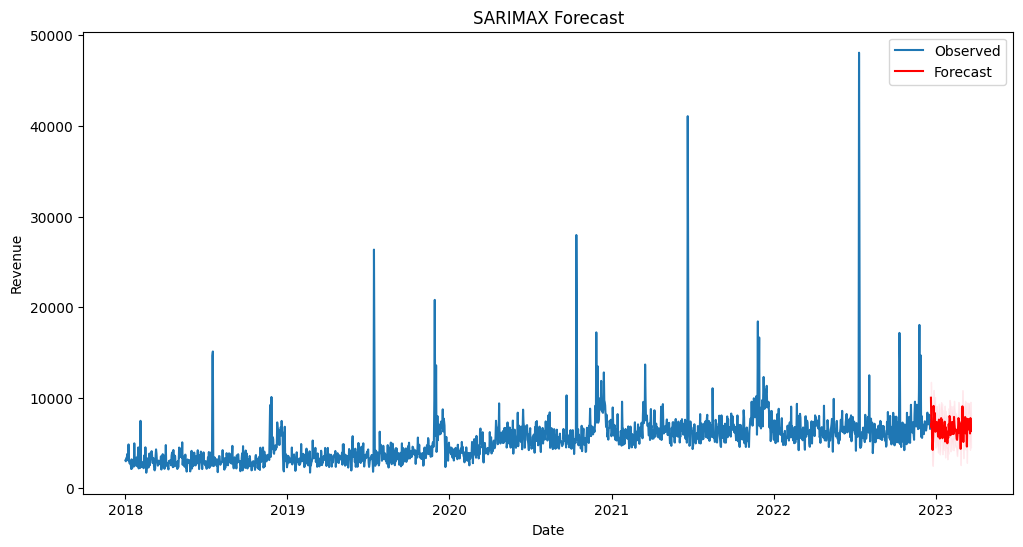

In [606]:
#SARIMAX
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Assuming aggregated_data is already loaded in the notebook
# Ensure the data is sorted by the index
aggregated_data = aggregated_data.sort_index()
aggregated_data.rename(columns={'Day of Week': 'Weekday'}, inplace=True)

exog_vars = aggregated_data[['prime_proportion', 'Prime Purchase', 'Prime Customer']]
# Fit SARIMAX Model
model = SARIMAX(aggregated_data["Revenue"], 
                order=(1, 1, 1),  # p, d, q
                seasonal_order=(1, 1, 1, 7),  # P, D, Q, s 
                exog=exog_vars)  # Exogenous variables
result = model.fit()

# Summary of the model
print(result.summary())

# Generate in-sample predictions
in_sample_predictions = result.predict(start=aggregated_data.index[0], end=aggregated_data.index[-1], exog=exog_vars)

# Forecast steps
days_in_month = 365 / 12
forecast_steps = int(3 * days_in_month)  # Forecast for 12 months

# Assuming you have future exogenous variables for the forecast period
# If not, you can use the last available exogenous variables or create a placeholder
exog_forecast = exog_vars.loc[pd.to_datetime('2021-12-21'):pd.to_datetime('2021-12-21') + pd.Timedelta(days=90)]

# Forecast
forecast = result.get_forecast(steps=forecast_steps, exog=exog_forecast)
forecast_values = forecast.predicted_mean
conf_int = forecast.conf_int()

# Plot the original data and the SARIMAX in-sample predictions
plt.figure(figsize=(12, 6))
plt.plot(aggregated_data["Revenue"], label="Observed")
plt.plot(in_sample_predictions, label="SARIMAX Fit", color='green')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.title('SARIMAX In-Sample Fit')
plt.legend()
plt.show()

# Plot the original data and the SARIMAX forecast
plt.figure(figsize=(12, 6))
plt.plot(aggregated_data["Revenue"], label="Observed")
plt.plot(forecast_values, label="Forecast", color='red')
plt.fill_between(conf_int.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.title('SARIMAX Forecast')
plt.legend()
plt.show()

In [ ]:
# Calculate accuracy metrics
mae = mean_absolute_error(aggregated_data["Revenue"], in_sample_predictions)
rmse = np.sqrt(mean_squared_error(aggregated_data["Revenue"], in_sample_predictions))

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

avg_revenue = aggregated_data["Revenue"].mean()
print(f"Average Revenue: {avg_revenue:.2f}")
print(f"MAE as % of Avg Revenue: {mae / avg_revenue * 100:.2f}%")
print(f"RMSE as % of Avg Revenue: {rmse / avg_revenue * 100:.2f}%")

Mean Absolute Error (MAE): 989.24
Root Mean Squared Error (RMSE): 2027.68
Average Revenue: 5276.44
MAE as % of Avg Revenue: 18.75%
RMSE as % of Avg Revenue: 38.43%


In [ ]:
x

,Year,Month,Day,Day of Week,prime_proportion
0,2018,1,1,0,0.940299
1,2018,1,2,1,0.919075
2,2018,1,3,2,0.885870
3,2018,1,4,3,0.922652
4,2018,1,5,4,0.887324
...,...,...,...,...,...
1810,2022,12,16,4,0.962025
1811,2022,12,17,5,0.983380
1812,2022,12,18,6,0.921348
1813,2022,12,19,0,0.971338


# Prediction & Validation

In [607]:
import plotly.graph_objects as go

# Create a figure
fig = go.Figure()

# Add the actual revenue data
fig.add_trace(go.Scatter(x=revenue.index, y=revenue, mode='lines', name='Actual Revenue', line=dict(color='blue')))

# Add the Exponential Smoothing model
fig.add_trace(go.Scatter(x=combined_data.index, y=combined_data['Model'], mode='lines', name='Exponential Smoothing Model', line=dict(color='red')))

# Add the SARIMAX model
fig.add_trace(go.Scatter(x=aggregated_data.index, y=in_sample_predictions, mode='lines', name='SARIMAX Model', line=dict(color='green')))

# Add the GAM model
fig.add_trace(go.Scatter(x=x.index, y=gam.predict(x), mode='lines', name='GAM Model', line=dict(color='purple')))

# Update layout
fig.update_layout(title='Revenue Model Comparison',
                  xaxis_title='Date',
                  yaxis_title='Revenue',
                  template='plotly_white')

# Add the Exponential Smoothing forecast
fig.add_trace(go.Scatter(x=forecast_df.index, y=forecast_df['Forecast'], mode='lines', name='Exponential Smoothing Forecast', line=dict(color='red'), opacity=0.7))

# Add the SARIMAX forecast
fig.add_trace(go.Scatter(x=forecast_values.index, y=forecast_values, mode='lines', name='SARIMAX Forecast', line=dict(color='green'), opacity=0.7))

# Add the GAM forecast
fig.add_trace(go.Scatter(x=future_dates, y=future_predictions, mode='lines', name='GAM Forecast', line=dict(color='purple'), opacity=0.7))

# Show the plot
fig.show()


In [608]:
# Residual Plots

import plotly.express as px
import plotly.graph_objects as go

# Residual plot for GAM
gam_residuals = gam.deviance_residuals(x.iloc[:, :5], y)
fig = go.Figure()
fig.add_trace(go.Scatter(x=y, y=gam_residuals, mode='markers', name='GAM Residuals', marker=dict(color='blue', opacity=0.4)))

# Residual plot for Exponential Smoothing Model
exp_residuals = expModel.resid
fig.add_trace(go.Scatter(x=revenue, y=exp_residuals, mode='markers', name='Exponential Smoothing Residuals', marker=dict(color='red', opacity=0.4)))

# Residual plot for SARIMAX Model
sarimax_residuals = aggregated_data["Revenue"] - in_sample_predictions
fig.add_trace(go.Scatter(x=aggregated_data["Revenue"], y=sarimax_residuals, mode='markers', name='SARIMAX Residuals', marker=dict(color='green', opacity=0.4)))

# Update layout once at the end
fig.update_layout(title='Residual Plot for Models', xaxis_title='Observed', yaxis_title='Residuals')

fig.show()

In [609]:
# Calculate accuracy metrics
mae = mean_absolute_error(aggregated_data["Revenue"], in_sample_predictions)
rmse = np.sqrt(mean_squared_error(aggregated_data["Revenue"], in_sample_predictions))

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

avg_revenue = aggregated_data["Revenue"].mean()
print(f"Average Revenue: {avg_revenue:.2f}")
print(f"MAE as % of Avg Revenue: {mae / avg_revenue * 100:.2f}%")
print(f"RMSE as % of Avg Revenue: {rmse / avg_revenue * 100:.2f}%")
# Calculate accuracy metrics for Exponential Smoothing model
mae_exp = mean_absolute_error(revenue, expModel.fittedvalues)
rmse_exp = np.sqrt(mean_squared_error(revenue, expModel.fittedvalues))

print(f"Exponential Smoothing - Mean Absolute Error (MAE): {mae_exp:.2f}")
print(f"Exponential Smoothing - Root Mean Squared Error (RMSE): {rmse_exp:.2f}")

# Calculate accuracy metrics for SARIMAX model
mae_sarimax = mean_absolute_error(aggregated_data["Revenue"], in_sample_predictions)
rmse_sarimax = np.sqrt(mean_squared_error(aggregated_data["Revenue"], in_sample_predictions))

print(f"SARIMAX - Mean Absolute Error (MAE): {mae_sarimax:.2f}")
print(f"SARIMAX - Root Mean Squared Error (RMSE): {rmse_sarimax:.2f}")

# Calculate accuracy metrics for GAM model
mae_gam = mean_absolute_error(y_test, y_pred)
rmse_gam = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"GAM - Mean Absolute Error (MAE): {mae_gam:.2f}")
print(f"GAM - Root Mean Squared Error (RMSE): {rmse_gam:.2f}")

Mean Absolute Error (MAE): 619.15
Root Mean Squared Error (RMSE): 894.41
Average Revenue: 5276.44
MAE as % of Avg Revenue: 11.73%
RMSE as % of Avg Revenue: 16.95%
Exponential Smoothing - Mean Absolute Error (MAE): 1019.10
Exponential Smoothing - Root Mean Squared Error (RMSE): 2162.65
SARIMAX - Mean Absolute Error (MAE): 619.15
SARIMAX - Root Mean Squared Error (RMSE): 894.41
GAM - Mean Absolute Error (MAE): 1018.64
GAM - Root Mean Squared Error (RMSE): 1793.36


In [ ]:
average_prices = subset_data.groupby(['Category','Prime Purchase'])['Revenue'].mean()

# Calculate the difference in mean between prime purchase 0 and 1 for each category
average_prices_diff = average_prices.unstack().diff(axis=1).iloc[:, -1].reset_index()
average_prices_diff.columns = ['Category', 'Difference']
# Calculate prime purchase quantities
prime_purchase_quantities = subset_data.groupby(['Category', 'Prime Purchase'])['Quantity'].sum().unstack().reset_index()
# Calculate the proportion of purchase quantities
prime_purchase_quantities.columns = ['Category', 'Non-Prime Purchase Quantity', 'Prime Purchase Quantity']
prime_purchase_quantities['Proportion'] = prime_purchase_quantities['Prime Purchase Quantity'] / (prime_purchase_quantities['Non-Prime Purchase Quantity'] + prime_purchase_quantities['Prime Purchase Quantity'])


# Merge with average_prices_diff to display the results together
average_prices_diff = pd.merge(average_prices_diff, prime_purchase_quantities, on='Category', how='left')

# Display the top 40 values
top_differences = average_prices_diff
top_differences = top_differences[(top_differences['Difference'] > 0) & (top_differences['Proportion'] > 0.035)]
top_differences.head(40)

In [600]:
# Get the unique categories in subset_data
subset_categories = set(subset_data['Category'].unique())

# Get the categories in top_differences
top_differences_categories = set(top_differences['Category'].unique())

# Find the categories in subset_data that are not in top_differences
categories_not_in_top_differences = subset_categories - top_differences_categories

# Count the number of such categories
num_categories_not_in_top_differences = len(categories_not_in_top_differences)
num_categories_not_in_top_differences

1600

In [599]:
# Filter the data for the category "DIGITAL_DEVICE_3"
top_products_data = subset_data[subset_data['Category'].isin(top_differences['Category'])]

# Plot the distribution of prices for "HEALTH_PERSONAL_CARE" colored by prime purchase using plotly express
fig = px.histogram(top_products_data, x='Purchase Price Per Unit', color='Prime Purchase', nbins=50, marginal='box', title='Distribution of Prices for Top Products by Prime Purchase')
fig.update_layout(xaxis_title='Purchase Price Per Unit', yaxis_title='Frequency')
fig.show()

In [ ]:

subset_data_with_top_diff = subset_data[subset_data['Category'].isin(top_differences['Category'])]
subset_data_with_top_diff.head()

,Order Date,Purchase Price Per Unit,Quantity,Shipping Address State,Title,ASIN/ISBN (Product Code),Category,Survey ResponseID,Prime Purchase,Prime Customer,...,Q-sell-YOUR-data,Q-sell-consumer-data,Q-small-biz-use,Q-census-use,Q-research-society,Revenue,Year,Month,Day,Day of Week
267,2019-02-13,20.99,1.0,PA,Hand Held Steamer for Clothes - Portable Cloth...,B07JRBKQVX,GARMENT_STEAMER,R_037XK72IZBJyF69,0,1,...,Yes if I get part of the profit,Yes if consumers get part of the profit,I don't know,No,Yes,20.99,2019,2,13,2
290,2019-07-16,22.95,1.0,PA,Ball Mason Jars 32 oz Wide Mouth Bundle with N...,B07GJ13K9T,ABIS_HOME,R_037XK72IZBJyF69,1,1,...,Yes if I get part of the profit,Yes if consumers get part of the profit,I don't know,No,Yes,22.95,2019,7,16,1
443,2020-05-16,25.99,1.0,PA,Mr. Coffee Simple Brew Coffee Maker|4 Cup Coff...,B003W8JSH8,COFFEE_MAKER,R_037XK72IZBJyF69,0,1,...,Yes if I get part of the profit,Yes if consumers get part of the profit,I don't know,No,Yes,25.99,2020,5,16,5
448,2020-05-21,16.49,1.0,PA,"Amazon Basics Slim, Velvet, Non-Slip Suit Clot...",B0756DXV8M,CLOTHES_HANGER,R_037XK72IZBJyF69,0,1,...,Yes if I get part of the profit,Yes if consumers get part of the profit,I don't know,No,Yes,16.49,2020,5,21,3
707,2021-03-26,107.99,1.0,PA,"Fire HD 10 Tablet (10.1"" 1080p full HD display...",B07KD7CW5T,AMAZON_TABLET,R_037XK72IZBJyF69,0,1,...,Yes if I get part of the profit,Yes if consumers get part of the profit,I don't know,No,Yes,107.99,2021,3,26,4


In [612]:
# Group by cluster and Date and aggregate the quantity and purchase prices
aggregated_diff_data = subset_data_with_top_diff.groupby(['Order Date']).agg({
    'Quantity': 'sum',
    'Revenue': 'sum',
    'Prime Purchase': lambda x: 1 if x.sum() > 0 else 0,
    'Prime Customer': 'sum'
}).reset_index()

# Add a column for the year, month, day, and day of the week
aggregated_diff_data['Year'] = aggregated_diff_data['Order Date'].dt.year
aggregated_diff_data['Month'] = aggregated_diff_data['Order Date'].dt.month
aggregated_diff_data['Day'] = aggregated_diff_data['Order Date'].dt.day
aggregated_diff_data['Day of Week'] = aggregated_diff_data['Order Date'].dt.dayofweek

# Display the first few rows of the aggregated data
aggregated_diff_data['prime_proportion'] = aggregated_diff_data['Prime Customer'] / aggregated_diff_data['Quantity']
aggregated_diff_data.head()

,Order Date,Quantity,Revenue,Prime Purchase,Prime Customer,Year,Month,Day,Day of Week,prime_proportion
0,2018-01-01,1.0,5.99,0,1,2018,1,1,0,1.0
1,2018-01-02,2.0,22.99,0,2,2018,1,2,1,1.0
2,2018-01-03,10.0,167.02,0,8,2018,1,3,2,0.8
3,2018-01-04,2.0,129.94,0,2,2018,1,4,3,1.0
4,2018-01-05,1.0,12.48,0,1,2018,1,5,4,1.0


In [613]:
aggregated_diff_data.set_index('Order Date', inplace=True)

In [634]:
from statsmodels.tsa.api import ExponentialSmoothing

import plotly.express as px

# Extract the Revenue series
revenue_diff = aggregated_diff_data['Quantity']
revenue_diff.index = aggregated_diff_data.index

# Fit the Exponential Smoothing model
exp_model_diff = ExponentialSmoothing(revenue_diff, trend='add', seasonal='add', seasonal_periods=30).fit()

# Generate the fitted values and forecast
fitted_values_diff = exp_model_diff.fittedvalues
forecast_diff = exp_model_diff.forecast(90)

# Create a DataFrame with the actual revenue, fitted values, and forecast
combined_data_diff = pd.DataFrame({
    'Actual': revenue_diff,
    'Fitted': fitted_values_diff
}, index=revenue_diff.index)

# Add the forecast to the DataFrame
forecast_dates_diff = pd.date_range(start=revenue_diff.index[-1], periods=90, freq='D')
forecast_df_diff = pd.DataFrame({
    'Forecast': forecast_diff
}, index=forecast_dates_diff)

# Combine the actual, fitted, and forecast data
combined_data_diff = pd.concat([combined_data_diff, forecast_df_diff])

# Plot the data using Plotly
fig = px.line(combined_data_diff, y=['Actual', 'Fitted', 'Forecast'], 
              title='Exponential Smoothing Forecast on Aggregated Diff Data', 
              labels={'value': 'Quantity', 'variable': 'Type'},
              x=combined_data_diff.index,
              color_discrete_map={
                  "Actual": 'blue',
                  'Fitted': 'red',
              })

# Add the forecast to the plot
fig.add_scatter(x=forecast_dates_diff, y=forecast_diff, mode='lines', name='Forecast', line=dict(color='green'))

fig.show()

C:\Users\nicko\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\nicko\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

C:\Users\nicko\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.



In [675]:
import pymc as pm

with pm.Model() as model:
    alpha = 1/top_products_data['Purchase Price Per Unit'].mean()

    lambda_1 = pm.Exponential("lambda_1", alpha)

    observation = pm.Exponential("obs", lambda_1, observed=top_products_data['Purchase Price Per Unit'])


In [681]:
top_products_data['Purchase Price Per Unit']

267         20.99
290         22.95
443         25.99
448         16.49
707        107.99
            ...  
1850513     49.99
1850540      8.89
1850564     21.99
1850587      6.99
1850595      4.99
Name: Purchase Price Per Unit, Length: 13087, dtype: float64

In [680]:
top_products_data['Purchase Price Per Unit'].mean()

47.38869947275923

In [676]:
with model:
    step = pm.Metropolis()
    trace = pm.sample(897, tune=100, chains=1, step=step, return_inferencedata=False)

Sequential sampling (1 chains in 1 job)
Metropolis: [lambda_1]


C:\Users\nicko\AppData\Roaming\Python\Python312\site-packages\rich\live.py:231: UserWarning:

install "ipywidgets" for Jupyter support

C:\Users\nicko\AppData\Roaming\Python\Python312\site-packages\pymc\step_methods\metropolis.py:313: RuntimeWarning:

overflow encountered in exp

Sampling 1 chain for 100 tune and 897 draw iterations (100 + 897 draws total) took 706 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


In [ ]:
subset_data[subset_data['Category'].isin(top_differences['Category'])]

In [688]:
# Sample 897 items from the 'Purchase Price Per Unit' column
sampled_prices = top_products_data['Purchase Price Per Unit'].sample(n=897, random_state=42)
sample_rest = subset_data[subset_data['Category'].isin(top_differences['Category'])]['Purchase Price Per Unit'].sample(n=866)

# Display the sampled prices
sum(sampled_prices) - sum(sample_rest)

1715.3499999999985

In [673]:
sum(lambda_1_samples[:897])

18.857141174568675

In [669]:
sum(forecast_diff) * 1

866.4501881774601

C:\Users\nicko\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\nicko\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



                                     SARIMAX Results                                     
Dep. Variable:                           Revenue   No. Observations:                 1796
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood              -12516.990
Date:                           Mon, 16 Dec 2024   AIC                          25049.980
Time:                                   20:50:53   BIC                          25093.891
Sample:                                        0   HQIC                         25066.195
                                          - 1796                                         
Covariance Type:                             opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
prime_proportion  -129.9576    121.412     -1.070      0.284    -367.921     108.006
Prime Purchase     620.36

C:\Users\nicko\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

C:\Users\nicko\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.



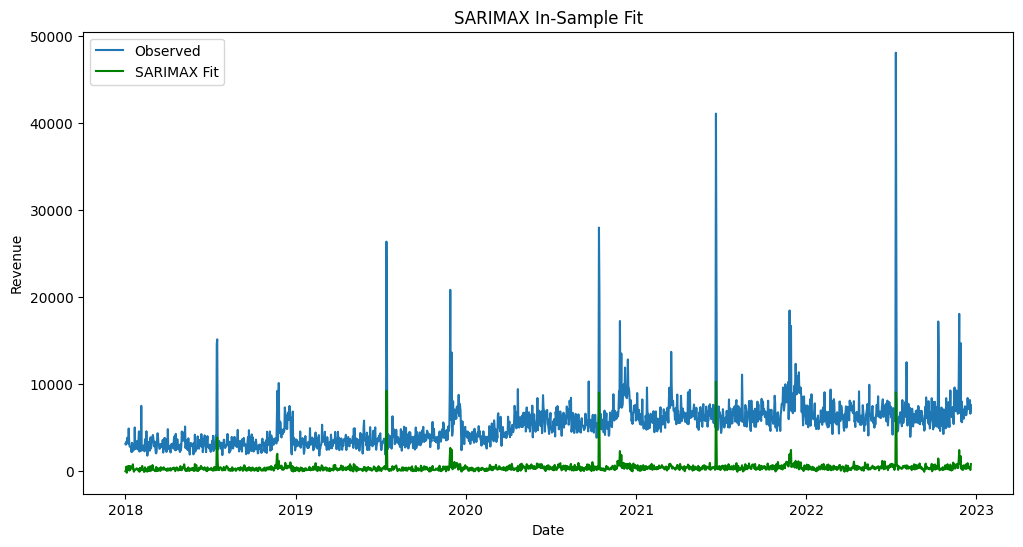

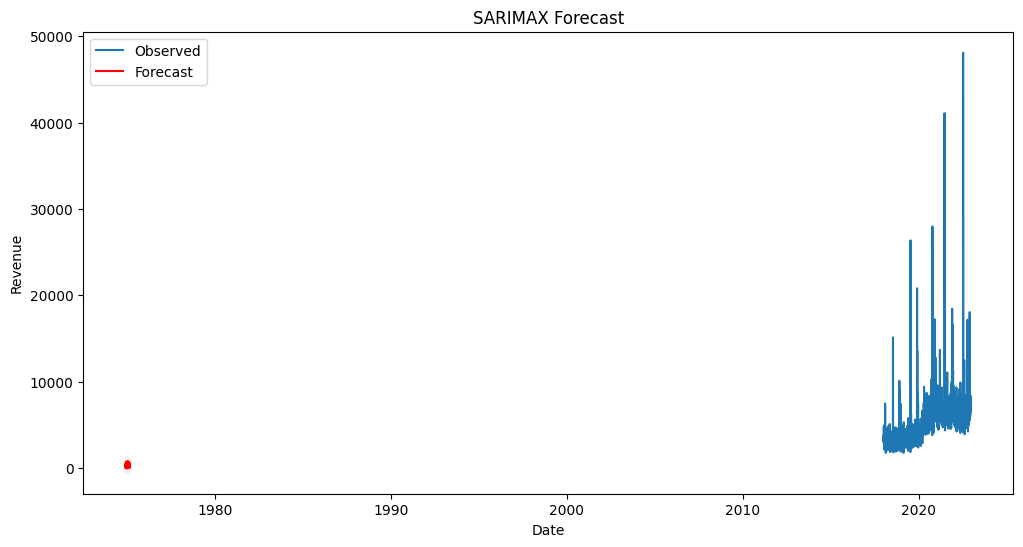

In [614]:
# Assuming aggregated_data is already loaded in the notebook
# Ensure the data is sorted by the index
aggregated_diff_data = aggregated_diff_data.sort_index()
aggregated_diff_data.rename(columns={'Day of Week': 'Weekday'}, inplace=True)

exog_vars = aggregated_diff_data[['prime_proportion', 'Prime Purchase', 'Prime Customer']]
# Fit SARIMAX Model
model = SARIMAX(aggregated_diff_data["Revenue"], 
                order=(1, 1, 1),  # p, d, q
                seasonal_order=(1, 1, 1, 7),  # P, D, Q, s 
                exog=exog_vars)  # Exogenous variables
result = model.fit()

# Summary of the model
print(result.summary())

# Generate in-sample predictions
in_sample_predictions = result.predict(start=aggregated_diff_data.index[0], end=aggregated_diff_data.index[-1], exog=aggregated_diff_data[["Quantity"]])

# Forecast steps
days_in_month = 365 / 12
forecast_steps = int(3 * days_in_month)  # Forecast for 12 months

# Assuming you have future exogenous variables for the forecast period
# If not, you can use the last available exogenous variables or create a placeholder
exog_forecast = exog_vars.loc[pd.to_datetime('2021-12-21'):pd.to_datetime('2021-12-21') + pd.Timedelta(days=90)]

# Forecast
forecast = result.get_forecast(steps=forecast_steps, exog=exog_forecast)
forecast_values = forecast.predicted_mean
conf_int = forecast.conf_int()

# Plot the original data and the SARIMAX in-sample predictions
plt.figure(figsize=(12, 6))
plt.plot(aggregated_data["Revenue"], label="Observed")
plt.plot(in_sample_predictions, label="SARIMAX Fit", color='green')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.title('SARIMAX In-Sample Fit')
plt.legend()
plt.show()

# Plot the original data and the SARIMAX forecast
plt.figure(figsize=(12, 6))
plt.plot(aggregated_data["Revenue"], label="Observed")
plt.plot(forecast_values, label="Forecast", color='red')
plt.fill_between(conf_int.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.title('SARIMAX Forecast')
plt.legend()
plt.show()